In [1]:
%run create_datasets.py 100000 1000000 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
import shutil
import math
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
import visualize  # visualize.py #for visualization
import json
from pathlib import Path


In [3]:
cwd_path = os.path.abspath('')
print(cwd_path)
parent_path = Path(cwd_path).parent
print(parent_path)


/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/codes
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition


In [4]:
json_f = open(f"{parent_path}/keys.json","r")
print(json_f)
parameters = json.load(json_f)
TRAIN_DIR = parameters["train_dir"]
TEST_DIR = parameters["test_dir"]
META_DIR = parameters["meta_dir"]
BACKUP_DIR = parameters["backup_dir"]
LEARNING_RATE = parameters["learning_rate"]
EPOCHS = parameters["epochs"]
BATCH_SIZE = parameters["batch_size"]
IMAGE_SIZE = parameters["image_size"]
CONV2D_TYPE_NUM_LIST = list(map(lambda x: float(x), parameters["conv2d_type"].split(",")))
POOL_SIZE_LIST = list(map(lambda x: float(x), parameters["pool_size"].split(",")))
DROPOUT_AFTER_POOLING = (lambda x:  x == "True")(parameters["dropout_after_pooling"])
DROPOUT_AFTER_POOLING_PERCENTAGE = float(parameters["dropout_after_pooling_percentage"]) 
DROPOUT_AFTER_FLATTEN = (lambda x:  x == "True")(parameters["dropout_after_flatten"])
DROPOUT_AFTER_FLATTEN_PERCENTAGE = float(parameters["dropout_after_flatten_percentage"])
DENSE_COUNT_LIST = list(map(lambda x: float(x), parameters["dense_count_list"].split(",")))
DROPOUT_AFTER_DENSE = (lambda x:  x == "True")(parameters["dropout_after_dense"])
DROPOUT_AFTER_DENSE_PERCENTAGE = float(parameters["dropout_after_dense_percentage"])

train_dir = f"{parent_path }/{TRAIN_DIR}"
test_dir = f"{parent_path }/{TEST_DIR}"
meta_dir = f"{parent_path }/{META_DIR}"
backup_dir = f"{parent_path }/{BACKUP_DIR}"

print(f"TRAIN_DIR:{train_dir}")
print(f"TEST_DIR:{test_dir}")
print(f"META_DIR:{meta_dir}")
print(f"BACKUP_DIR:{backup_dir}")


<_io.TextIOWrapper name='/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/keys.json' mode='r' encoding='UTF-8'>
TRAIN_DIR:/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Train_use
TEST_DIR:/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use
META_DIR:/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Meta
BACKUP_DIR:/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/model


In [5]:
#check tensorflow version
print(f"tensorflow version:{tf.__version__}")

tensorflow version:2.5.0


In [6]:
#list of labels from train_use/1 ....  
#create labels from Train_use/1 ...
labels = [d for d in os.listdir(
    train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()

In [7]:
#delete backup
if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)
    
#create backup directory 
os.makedirs(backup_dir)


In [8]:
#save label list to files
with open(f"{backup_dir}/labels.txt", 'w') as f:
    for label in labels:
        f.write(label+"\n") 


In [9]:
# read label from file
NUM_CLASSES = len(labels)
print(f"class number = {NUM_CLASSES}")

class number = 42


In [10]:
# read label from file
labels =  []
with open(f"{backup_dir}/labels.txt","r") as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [11]:
#image data's RGB is 0-255 so, divide all the pixil by 255 to express by 0~1
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

In [12]:
train_data = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    color_mode = 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

Found 38999 images belonging to 42 classes.


In [13]:
#test_data
validation_data = val_data_gen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Found 12570 images belonging to 42 classes.


In [14]:
#visualize.pick_train_sample(labels, train_data)


In [15]:
#AI model definition 
model = Sequential()

2022-01-15 12:53:59.178204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
#Conv2D layer
for Conv2D_type_num in CONV2D_TYPE_NUM_LIST:
    model.add(Conv2D(Conv2D_type_num,(3,3), padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Activation('relu'))

In [17]:
#MaxPooling layer
for POOL_SIZE in POOL_SIZE_LIST:
    model.add(MaxPooling2D(pool_size=(POOL_SIZE,POOL_SIZE)))
#Dropout layer
if(DROPOUT_AFTER_POOLING):
    model.add(Dropout(DROPOUT_AFTER_POOLING_PERCENTAGE))


In [18]:
#Flatten layer
model.add(Flatten())
if(DROPOUT_AFTER_FLATTEN):
    model.add(Dropout(DROPOUT_AFTER_FLATTEN_PERCENTAGE))    

In [19]:

#Dense layer
for Dense_count in DENSE_COUNT_LIST:
    model.add(Dense(Dense_count))
    model.add(Activation('relu'))
    if (DROPOUT_AFTER_DENSE):
        model.add(Dropout(DROPOUT_AFTER_DENSE_PERCENTAGE))

In [20]:
#Output layer(Last Dense Layer)
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

In [21]:
#Optimization Algorithm 
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

/Users/ryukomura_laptop/.pyenv/versions/3.9.5/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
#
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 2)         56        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 2)         38        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 2)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 2)         0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [24]:
class MyCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    f = open('weight_transition.txt','a')
    f.write('###EPOCH{}###\n'.format(epoch))
    
    f.write(str(self.model.layers[6].variables) + '\n')
    f.close()

In [25]:
#Execute train 
history = model.fit(train_data, epochs=EPOCHS,
                    validation_data=validation_data, verbose=1, callbacks=[MyCallBack()],)


Epoch 1/60


2022-01-15 12:53:59.622780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


19500/19500 [==============================] - 114s 6ms/step - loss: 2.1395 - accuracy: 0.3744 - val_loss: 1.3278 - val_accuracy: 0.6198
Epoch 2/60
19500/19500 [==============================] - 74s 4ms/step - loss: 1.6392 - accuracy: 0.4909 - val_loss: 1.1409 - val_accuracy: 0.6640
Epoch 3/60
19500/19500 [==============================] - 65s 3ms/step - loss: 1.5554 - accuracy: 0.5187 - val_loss: 1.0847 - val_accuracy: 0.7116
Epoch 4/60
19500/19500 [==============================] - 65s 3ms/step - loss: 1.5201 - accuracy: 0.5262 - val_loss: 1.0042 - val_accuracy: 0.7179
Epoch 5/60
19500/19500 [==============================] - 67s 3ms/step - loss: 1.4912 - accuracy: 0.5362 - val_loss: 1.0420 - val_accuracy: 0.7076
Epoch 6/60
19500/19500 [==============================] - 65s 3ms/step - loss: 1.4882 - accuracy: 0.5391 - val_loss: 1.0917 - val_accuracy: 0.7016
Epoch 7/60
19500/19500 [==============================] - 61s 3ms/step - loss: 1.4683 - accuracy: 0.5460 - val_loss: 0.9524 - va

In [26]:
score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6285/6285 [==============================] - 12s 2ms/step - loss: 1.0439 - accuracy: 0.7178
Test loss: 1.0438671112060547
Test accuracy: 0.7178202271461487


Confusion Matrix


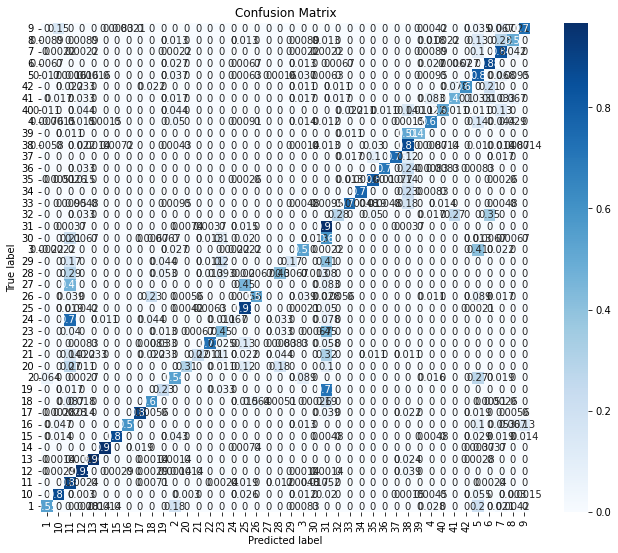

In [27]:
# Failed pictures
#visualize.vis_failed_pic(model, labels, validation_data,test_dir, BATCH_SIZE, 100)

# Visualize loss
visualize.vis_loss_accuracy(history, EPOCHS)

# Save model
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

# pickle_out = open(f"{parent_path}/model/my_model.pickle", "wb")
# pickle.dump(model, pickle_out)

# tf.keras.models.save_model(model, f"{parent_path}/model/")
# pickle_out.close()

# Confusion Matrix
visualize.vis_confusion_matrix(model, validation_data)


In [28]:
#visualize.vis_filter(model, 'conv2d')



In [29]:
!cat incorrect.txt


/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/00285.png
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/00314.png
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/00794.png
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/00982.png
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/01303.png
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/02154.png
/Users/ryukomura_laptop/Library/Mobile Documents/com~apple~CloudDocs/programming/TrafficSignRecognition/image_datasets/Test_use/1/02307.png
/Users/ryukomura_lap